In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
def quantize(x, s):
    return int(np.clip(np.round(s*x), -128, 127))

def sigmoid(x): 
    return 1 / (1 + math.exp(-x))

# https://sci-hub.se/10.1109/ICENCO48310.2019.9027479
def zaki_sig_default(x):
    if x >= 0:
        return (math.log2((2 * x) + 0.486) / 8) + 0.63
    else:
        return (-math.log2((-x * 0.5) + 0.008458) / 16) + 0.07

def zaki_sigq(x, s):
    x = quantize(x, s)
    if x >= 0:
        return (quantize(math.log2((x << 1) + 127), s) >> 3) + quantize(0.63, 409.30)
    else:
        return -(quantize(math.log2(-(x >> 1) + 3), s) >> 4) + quantize(0.07, 409.30)

In [3]:
val = -12.121
print(sigmoid(val))
print(zaki_sig_default(val))

5.443951163233243e-06
-0.09259055228337995


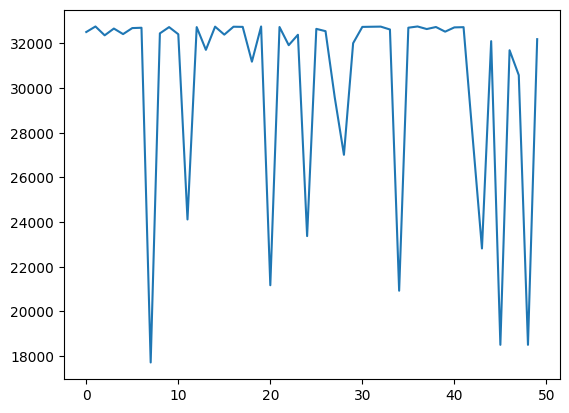

In [4]:
arr = 5 * np.random.random_sample((150,))
x = [i for i in range(-10, 11)]
ys = []
ys.append(("logistic", [32510,32758,32362,32665,32417,32686,32701,17715,32449,32730,32411,24118,32730,31712,32750,32393,32747,32740,31182,32757,21173,32734,31921,32387,23373,32651,32548,29586,27013,32010,32739,32746,32752,32623,20928,32703,32758,32643,32734,32526,32717,32727,27745,22819,32101,18505,31695,30579,18505,32190]))
#ys.append(("default",  [100 * sigmoid(i) for i in x]))
#ys.append(("zaki", [zaki_sig_default(i) for i in x]))
#ys.append(("zaki_q", [zaki_sigq(i, 409.30) for i in x]))
for (name, li) in ys:
    plt.plot(li, label=name)

In [5]:
array = [0.486, 0.00848, 0.63, 0.007]
s = 255 / (np.max(array) - np.min(array))

In [4]:
def normal_get(b, indices):
    return b[indices]

## Return strides array given shape 
def get_stride_vec(shape):
    li = []
    for i in range(len(shape)):
        product = np.prod(shape[i+1:])
        li.append(product)
    return np.array(li).astype(np.int32)

## auxillary
def get_with_stride(b, indices, strides):
    stride = np.sum(strides * indices)
    #print(f"index: {stride}")
    #print(f"value: {b.flatten()[stride]}")
    return b.flatten()[stride]
    
def xget(b, indices):
    strides = get_stride_vec(b.shape)
    return get_with_stride(b, indices, strides)

## Permute array by perm
def perm(array, perm):
    return np.array(array)[perm]

def increment_vector(input_vector, limit_vector):
    if len(input_vector) != len(limit_vector):
        raise ValueError("Input vector and limit vector must have the same length")
    # Start from the last element of the vector
    current_index = len(input_vector) - 1
    # Increment the values until the limit is not exceeded
    while current_index >= 0:
        input_vector[current_index] += 1
        # Check if the current element exceeds its limit
        if input_vector[current_index] >= limit_vector[current_index]:
            # Reset the current element to 0 and move to the previous element
            input_vector[current_index] = 0
            current_index -= 1
        else:
            break
    if input_vector[0] >= limit_vector[0]:
        raise ValueError("The input vector has reached its limit")
    return input_vector

def xtranspose_generic(arr, p):
    size = np.prod(arr.shape)
    barr = np.zeros(size)
    astride = get_stride_vec(arr.shape)
    bstride = get_stride_vec(perm(arr.shape, p))
    ii = np.zeros(len(arr.shape)).astype(np.int32)
    for i in range(np.prod(arr.shape)):
        index = np.sum(bstride * perm(ii,p))
        #print(f"index: {index}")
        barr[index] = xget(arr, ii)
        ii = increment_vector(ii, arr.shape)
    return barr.astype(np.int32)


def get_concated_shape(a, b, axis):
    li = []
    for index, (i, j) in enumerate(zip(a.shape,a.shape)):
        if index == axis:
            li.append(i+j)
        else:
            li.append(i)
    return li

def get_concat_offset(shape, axis):
    return np.prod(shape[axis:])
   
def xconcat(a, b, axis):
    post_concat_shape = get_concated_shape(a, b, axis)
    post_concat_stride = get_stride_vec(post_concat_shape)
    barr = np.zeros(np.prod(post_concat_shape))
    ii = np.zeros(len(a.shape)).astype(np.int32)
    for i in range(np.prod(a.shape)):
        index = np.sum(post_concat_stride * ii)
        #if index <= 35000:
        #    print(f"xconcat write-index: {index}")
        print(f"old i {ii} new i {index}")
        barr[index] = xget(a, ii)
        ii = increment_vector(ii, a.shape)
    ii = np.zeros(len(b.shape)).astype(np.int32)
    print("first done")
    for i in range(np.prod(b.shape)):
        offset = get_concat_offset(b.shape, axis)
        index = np.sum(post_concat_stride * ii) + offset
        #if index <= 35000:
        #    print(f"xconcat write-index: {index}")
        barr[index] = xget(b, ii)
        print(f"old i {ii} new i {index}")
        ii = increment_vector(ii, b.shape)
    return barr

def xconcat_transpose_fuse(a, b, axis, transpose_perm):
    post_concat_shape = get_concated_shape(a, b, axis)
    post_concat_stride = get_stride_vec(post_concat_shape)
    barr = np.zeros(np.prod(post_concat_shape))
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            for k in range(a.shape[2]):
                index = np.sum(post_concat_stride * perm([i,j,k], transpose_perm))
                barr[index] = a[i,j,k]
    cnt = 0
    for i in range(b.shape[0]):
        for j in range(b.shape[1]):
            for k in range(b.shape[2]):
                cnt = cnt + 1
                offset = get_concat_offset(b.shape, axis)
                index = np.sum(post_concat_stride * perm([i,j,k], transpose_perm)) + offset
                barr[index] = b[i,j,k]
    return barr

In [ ]:
b = np.arange(84).reshape(4,3,7)
p = [1,0,2]
bt = np.transpose(b, p)
index = [1,2,1]
print(f"b stride: {get_stride_vec(b.shape)}, b shape: {b.shape}")
print(f"bt stride: {get_stride_vec(bt.shape)}, bt shape: {bt.shape}")
get_with_stride(b, get_stride_vec(b.shape), index)
get_with_stride(bt, get_stride_vec(bt.shape), perm(index, p))

In [ ]:
## TRANSPOSE EXAMPLE
tensor_size = (4,3,7,3,5)
arr = np.arange(np.prod(tensor_size)).reshape(tensor_size)
index = [2,0,1,4,3]
print(f"total size: {np.prod(tensor_size)}")
#xtranspose(arr, index) == 
xtranspose(arr, index) == np.transpose(arr, index).flatten()

In [93]:
## CONCAT

In [ ]:
tensor_size = (4,3,7,3)
arr = np.arange(np.prod(tensor_size)).reshape(tensor_size)
barr = xconcat(arr, arr, 2)
np.equal(barr, np.concatenate((arr, arr), axis=2).flatten())

In [3]:
import numpy as np
a = np.arange(84).reshape(4,3,7)
b = np.ones(84).reshape(4,3,7)
print(a.flatten())
print(np.concatenate((a,b), axis=0).flatten())
print(np.transpose(np.concatenate((a,b), axis=2), [2,0,1]).flatten())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.]
[ 0.  7. 14. 21. 28. 35. 42. 49. 56. 63. 70. 77.  1.  8. 15.

In [ ]:
for i,v in enumerate(np.concatenate((a,b), axis=2).flatten()):
    print(i,v)
    #if v != 1.0 and v % 7.0 == 0:
    #    print(i,v)

In [4]:
arr = np.arange(84).reshape(4,3,7)
np.transpose(np.concatenate((arr, arr), axis=1), [1,0,2]).flatten()
xtranspose(np.concatenate((arr, arr), axis=1), [1,0,2])

NameError: name 'xtranspose' is not defined

In [5]:
xconcat_transpose_fuse(arr, arr, 1, [1,0,2]).astype(np.int32)

NameError: name 'xconcat_transpose_fuse' is not defined

In [37]:
def inc1(arr):
    incr_vector =  []
    iv = [0, 0, 0]
    for i in range(np.prod(arr.shape)):
        incr_vector.append([iv])
        iv = increment_vector(iv, arr.shape)
    return incr_vector

def inc2(arr):
    incr_vector = []
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            for k in range(arr.shape[2]):
                incr_vector.append([i,j,k])
    return incr_vector

In [38]:
arr = np.arange(84).reshape(4,3,7)
print(inc1(arr))
print(inc2(arr))

[[[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]], [[0, 0, 1]]

In [50]:
ii = increment_vector(ii, arr.shape)

In [51]:
ii

[0, 0, 5]

In [10]:
#get_stride_vec([3,4,8])
arr.shape

(4, 3, 7)

In [ ]:
res = xconcat(arr, arr, 2)

In [14]:
res.shape

(168,)

In [ ]:
our_shape = np.arange(1*2*128*40*2*40).reshape(1,2,128,40,2,40)
xtranspose_generic(our_shape, [0,3,4,5,1,2])

In [8]:
arr = np.arange(18).reshape(3,3,2)
res = xtranspose_generic(arr, [0,2,1]).reshape(3,2,3)

In [12]:
xget(res, [2,0,1])

14

In [58]:
def read_transpose(arr, p):
    barr_shape = perm(arr.shape, p)
    print(f"new shape {barr_shape}")
    barr = np.zeros(np.prod(arr.shape))
    astride = get_stride_vec(arr.shape)
    bstride = get_stride_vec(barr_shape)
    ii = np.zeros(len(arr.shape)).astype(np.int32)
    for i in range(np.prod(barr_shape)):
        aindex = perm(ii, p)
        bindex = np.sum(bstride * ii)
        barr[bindex] = xget(arr, aindex)
        #print(f"bindex: {ii} aindex {aindex}")
        ii = increment_vector(ii, barr_shape)
    return barr.astype(np.int32)

def batch_transpose_fixed_chunk(arr, p, chunk_size):
    barr_shape = perm(arr.shape, p)
    barr = np.zeros(np.prod(arr.shape))
    astride = get_stride_vec(arr.shape)
    bstride = get_stride_vec(barr_shape)
    ii = np.zeros(len(arr.shape)).astype(np.int32)
    arr_flat = arr.flatten()
    chunk_num = 0
    chunk_load_cnt = 0
    print(f"astride: {astride}")
    print(f"barr_shape: {barr_shape}")
    for i in range(np.prod(barr_shape)):
        aindex = np.sum(perm(astride, p) * ii)
        bindex = np.sum(bstride * ii)
        chunk_addr_low = chunk_num * chunk_size
        chunk_addr_high = chunk_addr_low + chunk_size
        #print(f"{aindex}")
        if aindex < chunk_addr_low or aindex > chunk_addr_high:
            chunk_num = math.floor(aindex/chunk_size)
            #print(f"loading chunk {chunk_num}")
            chunk_load_cnt = chunk_load_cnt + 1
        barr[bindex] = arr_flat[aindex]
        ii = increment_vector(ii, barr_shape)
    print(f"total loads: {chunk_load_cnt}, each load costs: {chunk_size/32}, result {(chunk_load_cnt*(chunk_size/32))/1e5}")
    return barr.astype(np.int32).reshape(perm(arr.shape, p))

def batch_transpose_mid_chunk(arr, p, chunk_size):
    barr_shape = perm(arr.shape, p)
    barr = np.zeros(np.prod(arr.shape))
    astride = get_stride_vec(arr.shape)
    bstride = get_stride_vec(barr_shape)
    ii = np.zeros(len(arr.shape)).astype(np.int32)
    arr_flat = arr.flatten()
    chunk_addr = 0
    chunk_addr_low = chunk_addr
    chunk_addr_high = chunk_addr_low + chunk_size
    chunk_load_cnt = 0
    print(f"astride: {astride}")
    print(f"barr_shape: {barr_shape}")
    for i in range(np.prod(barr_shape)):
        aindex = np.sum(perm(astride, p) * ii)
        bindex = np.sum(bstride * ii)
        print(f"want {aindex}, chunk_low {chunk_addr_low}, chunk_high {chunk_addr_high}")
        if aindex < chunk_addr_low or aindex > chunk_addr_high:
            chunk_addr = math.floor((chunk_addr_high - chunk_addr_low)/2)
            chunk_addr_low = chunk_addr
            chunk_addr_high = chunk_addr_low + chunk_size
            print(f"loading chunk {chunk_addr}")
            chunk_load_cnt = chunk_load_cnt + 1
        barr[bindex] = arr_flat[aindex]
        ii = increment_vector(ii, barr_shape)
    print(f"total loads: {chunk_load_cnt}, each load costs: {chunk_size/32}, result {(chunk_load_cnt*(chunk_size/32))/1e5}")
    return barr.astype(np.int32).reshape(perm(arr.shape, p))

def batch_transpose_aot_chunk(arr, p, chunk_size):
    barr_shape = perm(arr.shape, p)
    barr = np.zeros(np.prod(arr.shape))
    astride = get_stride_vec(arr.shape)
    bstride = get_stride_vec(barr_shape)
    ii = np.zeros(len(arr.shape)).astype(np.int32)
    arr_flat = arr.flatten()
    chunk_addr = 0
    chunk_addr_low = chunk_addr
    chunk_addr_high = chunk_addr_low + chunk_size
    chunk_load_cnt = 0
    print(f"astride: {astride}")
    print(f"bstride: {bstride}")
    print(f"arr_shape: {arr.shape}")
    print(f"barr_shape: {barr_shape}")
    for i in range(np.prod(barr_shape)):
        aindex = np.sum(perm(astride, p) * ii)
        bindex = np.sum(bstride * ii)
        if aindex < chunk_addr_low or aindex > chunk_addr_high:
            chunk_addr = aindex - (aindex % 32)
            chunk_addr_low = chunk_addr
            chunk_addr_high = chunk_addr_low + chunk_size
            #print(f"loading chunk {chunk_addr}")
            chunk_load_cnt = chunk_load_cnt + 1
        print(f"want {aindex}, chunk_low {chunk_addr_low}, chunk_high {chunk_addr_high}")
        barr[bindex] = arr_flat[aindex]
        ii = increment_vector(ii, barr_shape)
    print(f"total loads: {chunk_load_cnt}, each load costs: {chunk_size/32}, result {(chunk_load_cnt*(chunk_size/32))/1e5}")
    return barr.astype(np.int32).reshape(perm(arr.shape, p))

# get vector index from a scalar index
def s2v_index(index, stridev):
    ret = []
    for i in stridev:
        ret.append(math.floor(index/i))
        index = index % i
    return ret

def batch_transpose_rw_aot(arr, p, chunk_size):
    barr_shape = perm(arr.shape, p)
    barr = np.zeros(np.prod(arr.shape))
    astride = get_stride_vec(arr.shape)
    bstride = get_stride_vec(barr_shape)
    # iterate over new arr
    ii = np.zeros(len(barr_shape)).astype(np.int32)
    jj = np.zeros(len(arr.shape)).astype(np.int32)
    arr_flat = arr.flatten()
    chunk_addr = 0
    chunk_addr_low = chunk_addr
    chunk_addr_high = chunk_addr_low + chunk_size
    chunk_load_cnt = 0
    print(f"astride: {astride}")
    print(f"barr_shape: {barr_shape}")
    for _ in range(np.prod(barr_shape)):
        # write sequential
        aindex = np.sum(perm(astride, p) * ii)
        bindex = np.sum(bstride * ii)#
        # read seq
        waindex = np.sum(astride * jj)
        wbindex = np.sum(bstride * perm(jj,p))
        if aindex < chunk_addr_low or aindex > chunk_addr_high:
            chunk_addr = aindex - (aindex % 32)
            chunk_addr_low = chunk_addr
            chunk_addr_high = chunk_addr_low + chunk_size
            print(f"loading chunk {chunk_addr}")
            chunk_load_cnt = chunk_load_cnt + 1
        #print(f"want {aindex}, chunk_low {chunk_addr_low}, chunk_high {chunk_addr_high}")
        print(f"read-seq: can write {arr_flat[waindex]} at {wbindex}")
        print(f"write-seq: can write {arr_flat[aindex]} at {bindex}")
        barr[bindex] = arr_flat[aindex]         
        #print(f"jj {jj}")
        ii = increment_vector(ii, barr_shape)
        # iterate over old arr
        jj = increment_vector(jj, arr.shape)
    print(f"total loads: {chunk_load_cnt}, each load costs: {chunk_size/32}, result {(chunk_load_cnt*(chunk_size/32))/1e5}")
    return barr.astype(np.int32).reshape(perm(arr.shape, p))

In [132]:
def increment_vector_n(vec, shape, n):
    for _ in range(n):
        vec = increment_vector(vec, shape)
    return vec

class Transpose:
    def __init__(self):
        self.dram_bandwidth_bytes = 32
        self.chunk_size = 32
        self.total_chunk_loads = 0
        self.chunk_addrl = 0
        self.chunk_addrh = self.chunk_addrl + self.chunk_size
        self.already_written_lines = np.zeros(0)
        self.cycles_per_process = 16
        self.num_checkers = 8
    
    def process_lowest_layer(self, arr, aindex, barr, bindex):
        if aindex < self.chunk_addrl or aindex > self.chunk_addrh:
                self.chunk_addrl = aindex - (aindex % self.dram_bandwidth_bytes)
                self.chunk_addrh = self.chunk_addrl + self.chunk_size
                print(f"loading chunk {self.chunk_addrl}")
                self.total_chunk_loads = self.total_chunk_loads + 1
        #print(f"writing at {bindex}")
        self.already_written_lines[bindex] = 1
        barr[bindex] = arr[aindex]
        return barr
            
    def process_higher_layers(self, arr, aindex, barr, bindex):
        if aindex > self.chunk_addrl or aindex < self.chunk_addrh:
            self.already_written_lines[bindex] = 1
            barr[bindex] = arr[aindex]
        #print(f"writing at {bindex}")
        return barr

    def get_write_cache_line(self, aindex):
        return aindex // self.dram_bandwidth_bytes
    
    def rw_aot(self, arr, p, chunk_size):
        barr_shape = perm(arr.shape, p)
        barr = np.zeros(np.prod(arr.shape))
        astride = get_stride_vec(arr.shape)
        bstride = get_stride_vec(barr_shape)
        # iterate over new arr
        jj = np.zeros(len(arr.shape)).astype(np.int32)
        arr_flat = arr.flatten()
        self.already_written_lines = np.zeros(len(barr))
        
        ii = np.zeros(len(barr_shape)).astype(np.int32)
        for _ in range(np.prod(arr.shape)):
            vertical_ii = ii
            for cycle in range(self.cycles_per_process):
                print(f"{vertical_ii}")
                aindex = np.sum(perm(astride, p) * vertical_ii)
                bindex = np.sum(bstride * vertical_ii)
                if self.already_written_lines[aindex] != 1:
                    barr = self.process_lowest_layer(arr_flat, aindex, barr, bindex)
                    #print(f"want {aindex} from {bindex}")
                    vertical_ii = increment_vector_n(vertical_ii, barr_shape, 32)
                    print(vertical_ii)
                for _ in range(self.num_checkers - 1):
                    aindex_copy = np.sum(perm(astride, p) * vertical_ii)
                    bindex_copy = np.sum(bstride * vertical_ii)
                    if self.already_written_lines[aindex] != 1:
                        barr = self.process_higher_layers(arr_flat, aindex_copy, barr, bindex_copy)
                        #print(f"want {aindex_copy} from {bindex_copy}")
                    vertical_ii = increment_vector_n(vertical_ii, barr_shape, 32)
                    print(vertical_ii)
                #print(f"In cycle {cycle}")
                ii = increment_vector(ii, barr_shape)
                #print(f"ii {ii}")
        return barr.reshape(barr_shape)

In [133]:
tt = Transpose()
shape = [3,2,4]
arr = np.arange(np.prod(shape)).reshape(shape)
p = [0,2,1]
tt.rw_aot(arr, p, 512)

[0 0 0]
[1 0 0]
[2 0 0]
[0 0 0]
[1 0 0]
[2 0 0]
[0 0 0]
[1 0 0]
[2 0 0]
[2 0 1]
[0 0 1]
[1 0 1]
[2 0 1]
[0 0 1]
[1 0 1]
[2 0 1]
[0 0 1]
[1 0 1]
[1 1 0]
[2 1 0]
[0 1 0]
[1 1 0]
[2 1 0]
[0 1 0]
[1 1 0]
[2 1 0]
[2 1 1]
[0 1 1]
[1 1 1]
[2 1 1]
[0 1 1]
[1 1 1]
[2 1 1]
[0 1 1]
[1 1 1]
[1 2 0]
[2 2 0]
[0 2 0]
[1 2 0]
[2 2 0]
[0 2 0]
[1 2 0]
[2 2 0]
[0 2 0]
[0 2 1]
[1 2 1]
[2 2 1]
[0 2 1]
[1 2 1]
[2 2 1]
[0 2 1]
[1 2 1]
[2 2 1]
[2 3 0]
[0 3 0]
[1 3 0]
[2 3 0]
[0 3 0]
[1 3 0]
[2 3 0]
[0 3 0]
[0 3 1]
[1 3 1]
[2 3 1]
[0 3 1]
[1 3 1]
[2 3 1]
[0 3 1]
[1 3 1]
[2 3 1]
[0 0 0]
[1 0 0]
[2 0 0]
[0 0 0]
[1 0 0]
[2 0 0]
[0 0 0]
[1 0 0]
[1 0 1]
[2 0 1]
[0 0 1]
[1 0 1]
[2 0 1]
[0 0 1]
[1 0 1]
[2 0 1]
[2 1 0]
[0 1 0]
[1 1 0]
[2 1 0]
[0 1 0]
[1 1 0]
[2 1 0]
[0 1 0]
[0 1 1]
[1 1 1]
[2 1 1]
[0 1 1]
[1 1 1]
[2 1 1]
[0 1 1]
[1 1 1]
[1 2 0]
[2 2 0]
[0 2 0]
[1 2 0]
[2 2 0]
[0 2 0]
[1 2 0]
[2 2 0]
[0 2 0]
[0 2 1]
[1 2 1]
[2 2 1]
[0 2 1]
[1 2 1]
[2 2 1]
[0 2 1]
[1 2 1]
[2 2 1]
[2 3 0]
[0 3 0]
[1 3 0]
[2 3 0]
[0 3 0]


array([[[ 0.,  4.],
        [ 0.,  5.],
        [ 2.,  6.],
        [ 0.,  7.]],

       [[ 8., 12.],
        [ 0., 13.],
        [10., 14.],
        [ 0., 15.]],

       [[16., 20.],
        [ 0., 21.],
        [18., 22.],
        [ 0., 23.]]])

In [66]:
my_l = [1,2,3,4]
def foo(ll):
    ll.append(336)
print(my_l)
foo(my_l)
print(my_l)

[1, 2, 3, 4]
[1, 2, 3, 4, 336]


In [ ]:
arr = np.arange(1*2*128*40*2*40).reshape(1,2,128,40,2,40)
p = [0,5,1,2,3,4]
batch_transpose_aot_chunk(arr, p, 512)

In [65]:
shape = [3,2,5,4]
arr = np.arange(np.prod(shape)).reshape(shape)
batch_transpose_aot_chunk(arr, [1,0,3,2], 512)

astride: [40 20  4  1]
bstride: [60 20  5  1]
arr_shape: (3, 2, 5, 4)
barr_shape: [2 3 4 5]
want 0, chunk_low 0, chunk_high 512
want 4, chunk_low 0, chunk_high 512
want 8, chunk_low 0, chunk_high 512
want 12, chunk_low 0, chunk_high 512
want 16, chunk_low 0, chunk_high 512
want 1, chunk_low 0, chunk_high 512
want 5, chunk_low 0, chunk_high 512
want 9, chunk_low 0, chunk_high 512
want 13, chunk_low 0, chunk_high 512
want 17, chunk_low 0, chunk_high 512
want 2, chunk_low 0, chunk_high 512
want 6, chunk_low 0, chunk_high 512
want 10, chunk_low 0, chunk_high 512
want 14, chunk_low 0, chunk_high 512
want 18, chunk_low 0, chunk_high 512
want 3, chunk_low 0, chunk_high 512
want 7, chunk_low 0, chunk_high 512
want 11, chunk_low 0, chunk_high 512
want 15, chunk_low 0, chunk_high 512
want 19, chunk_low 0, chunk_high 512
want 40, chunk_low 0, chunk_high 512
want 44, chunk_low 0, chunk_high 512
want 48, chunk_low 0, chunk_high 512
want 52, chunk_low 0, chunk_high 512
want 56, chunk_low 0, chunk_hi

array([[[[  0,   4,   8,  12,  16],
         [  1,   5,   9,  13,  17],
         [  2,   6,  10,  14,  18],
         [  3,   7,  11,  15,  19]],

        [[ 40,  44,  48,  52,  56],
         [ 41,  45,  49,  53,  57],
         [ 42,  46,  50,  54,  58],
         [ 43,  47,  51,  55,  59]],

        [[ 80,  84,  88,  92,  96],
         [ 81,  85,  89,  93,  97],
         [ 82,  86,  90,  94,  98],
         [ 83,  87,  91,  95,  99]]],


       [[[ 20,  24,  28,  32,  36],
         [ 21,  25,  29,  33,  37],
         [ 22,  26,  30,  34,  38],
         [ 23,  27,  31,  35,  39]],

        [[ 60,  64,  68,  72,  76],
         [ 61,  65,  69,  73,  77],
         [ 62,  66,  70,  74,  78],
         [ 63,  67,  71,  75,  79]],

        [[100, 104, 108, 112, 116],
         [101, 105, 109, 113, 117],
         [102, 106, 110, 114, 118],
         [103, 107, 111, 115, 119]]]], dtype=int32)

In [62]:
shape = [20,32,46,4]
arr = np.arange(np.prod(shape)).reshape(shape)
batch_transpose_aot_chunk(arr, [0,1,3,2], 512)

astride: [5888  184    4    1]
bstride: [5888  184   46    1]
arr_shape: (20, 32, 46, 4)
barr_shape: [20 32  4 46]
want 0, chunk_low 0, chunk_high 512
want 4, chunk_low 0, chunk_high 512
want 8, chunk_low 0, chunk_high 512
want 12, chunk_low 0, chunk_high 512
want 16, chunk_low 0, chunk_high 512
want 20, chunk_low 0, chunk_high 512
want 24, chunk_low 0, chunk_high 512
want 28, chunk_low 0, chunk_high 512
want 32, chunk_low 0, chunk_high 512
want 36, chunk_low 0, chunk_high 512
want 40, chunk_low 0, chunk_high 512
want 44, chunk_low 0, chunk_high 512
want 48, chunk_low 0, chunk_high 512
want 52, chunk_low 0, chunk_high 512
want 56, chunk_low 0, chunk_high 512
want 60, chunk_low 0, chunk_high 512
want 64, chunk_low 0, chunk_high 512
want 68, chunk_low 0, chunk_high 512
want 72, chunk_low 0, chunk_high 512
want 76, chunk_low 0, chunk_high 512
want 80, chunk_low 0, chunk_high 512
want 84, chunk_low 0, chunk_high 512
want 88, chunk_low 0, chunk_high 512
want 92, chunk_low 0, chunk_high 512


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
arr = np.arange(1*2*128*40*2*40).reshape(1,2,128,40,2,40)
#p = [0,2,3,4,5,1]
p = [0,3,4,5,1,2]
#for i in [512, 1024, 2048, 4096, 2**13, 2**14, 2**15, 2**16]:
#    batch_transpose(arr, [0,3,4,5,1,2], i)#.flatten() == np.transpose(arr, [0,3,4,5,1,2]).flatten()
#batch_transpose_aot_chunk(arr, p, 64)


In [87]:
shape = [2,128,40,2,40]
arr = np.arange(np.prod(shape)).reshape(shape)
for i in [512, 1024, 2048, 4096, 2**13, 2**14, 2**15, 2**16]:
    batch_transpose(arr, [0,2,3,4,1], i)

astride: [409600   3200     80     40      1]
total loads: 69829, each load costs: 16.0, result 11.17264
astride: [409600   3200     80     40      1]
total loads: 38057, each load costs: 32.0, result 12.17824
astride: [409600   3200     80     40      1]
total loads: 22141, each load costs: 64.0, result 14.17024
astride: [409600   3200     80     40      1]
total loads: 13791, each load costs: 128.0, result 17.65248
astride: [409600   3200     80     40      1]
total loads: 6559, each load costs: 256.0, result 16.79104
astride: [409600   3200     80     40      1]
total loads: 1, each load costs: 512.0, result 0.00512
astride: [409600   3200     80     40      1]
total loads: 1, each load costs: 1024.0, result 0.01024
astride: [409600   3200     80     40      1]
total loads: 1, each load costs: 2048.0, result 0.02048


In [115]:
shape = [1,2,3,4]
arr = np.arange(np.prod(shape)).reshape(shape)
batch_transpose(arr, [0,2,3,1], 16384)

astride: [24 12  4  1]
barr_shape: [1 3 4 2]
total loads: 0, each load costs: 512.0, result 0.0


array([[[[ 0, 12],
         [ 1, 13],
         [ 2, 14],
         [ 3, 15]],

        [[ 4, 16],
         [ 5, 17],
         [ 6, 18],
         [ 7, 19]],

        [[ 8, 20],
         [ 9, 21],
         [10, 22],
         [11, 23]]]], dtype=int32)

In [159]:
shape = [80,80]
arr = np.arange(np.prod(shape)).reshape(shape)
batch_transpose_aot_chunk(arr, [1,0], 512)

astride: [80  1]
barr_shape: [80 80]
total loads: 959, each load costs: 16.0, result 0.15344


array([[   0,   80,  160, ..., 6160, 6240, 6320],
       [   1,   81,  161, ..., 6161, 6241, 6321],
       [   2,   82,  162, ..., 6162, 6242, 6322],
       ...,
       [  77,  157,  237, ..., 6237, 6317, 6397],
       [  78,  158,  238, ..., 6238, 6318, 6398],
       [  79,  159,  239, ..., 6239, 6319, 6399]], dtype=int32)